# Convolutional AutoEncoder on Pokemon Dataset :

![](https://i2.wp.com/sefiks.com/wp-content/uploads/2018/03/convolutional-autoencoder.png?fit=1818%2C608&ssl=1)

Semi supervised learning has unfolded frontiers in deep learning.
AutoEncoders, a technique or idea in semi supervised learning contributes to computer visison a lot. AutoEncoder is normally a generative network as it regenerates the identical version of corresponding data.


In this notebook **Convolutional AutoEncoder** has been explained and implemented on pokemon dataset.
## Do STAR the repository if this helps you :)

Every project should have a sequential approach.
The contents are as follows :
              
              1. Data Loading and Visualization
              2. Image Preprocessing & Dataset Preparation
              3. Model Building
              4. Hyperparameter choosing
              5. Model Training
              6. Model Performnace Evaluation
              7. Encoder Preparation
              8. Conclusion

# 1. Data Loading and Visualization :
---
 At first we have to visualize to find out actual state of the images thus we can choose our data processing approach.

In [1]:
# To ignore all warnings in the outputs.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# To manipulate data directories
import os

In [3]:
os.mkdir('pokemon_jpg/')

In [4]:
cd /content/pokemon_jpg

/content/pokemon_jpg


In [5]:
!unzip /content/drive/MyDrive/pokemon_AE/pokemon_jpg.zip

Archive:  /content/drive/MyDrive/pokemon_AE/pokemon_jpg.zip
   creating: pokemon_jpg/
  inflating: pokemon_jpg/1.jpg       
  inflating: pokemon_jpg/10.jpg      
  inflating: pokemon_jpg/100.jpg     
  inflating: pokemon_jpg/101.jpg     
  inflating: pokemon_jpg/102.jpg     
  inflating: pokemon_jpg/103.jpg     
  inflating: pokemon_jpg/104.jpg     
  inflating: pokemon_jpg/105.jpg     
  inflating: pokemon_jpg/106.jpg     
  inflating: pokemon_jpg/107.jpg     
  inflating: pokemon_jpg/108.jpg     
  inflating: pokemon_jpg/109.jpg     
  inflating: pokemon_jpg/11.jpg      
  inflating: pokemon_jpg/110.jpg     
  inflating: pokemon_jpg/111.jpg     
  inflating: pokemon_jpg/112.jpg     
  inflating: pokemon_jpg/113.jpg     
  inflating: pokemon_jpg/114.jpg     
  inflating: pokemon_jpg/115-mega.jpg  
  inflating: pokemon_jpg/115.jpg     
  inflating: pokemon_jpg/116.jpg     
  inflating: pokemon_jpg/117.jpg     
  inflating: pokemon_jpg/118.jpg     
  inflating: pokemon_jpg/119.jpg     


In [6]:
# Current Image Directory
image_dir = '../content/pokemon_jpg/pokemon_jpg'

In [7]:
cd ..

/content


In [8]:
# To validate if augmentation is need or not 
print(f' Total count of Images : { len( os.listdir( image_dir ) ) }')

 Total count of Images : 819


We can see there are very less number of images. If we try to train the model with it , we may find high bias.
So, we need to augment the images.

In [9]:
# for image processing
import matplotlib.pyplot as plt
import cv2

In [10]:
# function to load image
def load(image_path):
  # read image from it's path
  img = cv2.imread(image_path)
  # convert to RGB from BGR
  img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
  # resize
  img = cv2.resize(img , (256,256))
    
  return img

# visualize images
def display(im_dir):
  # setting subplot structure
  fig , ax = plt.subplots(4 , 5 , figsize=(20 , 9))
  plt.suptitle('Pokemon Images' , size = 20)
 
  for i in range(20):
    # fetching image path
    img_path = os.path.join(im_dir , os.listdir(im_dir)[i])
    image = load(img_path)
    plt.subplot(4 , 5 , i + 1)
    plt.imshow(image)
    plt.axis('off')

  plt.show()

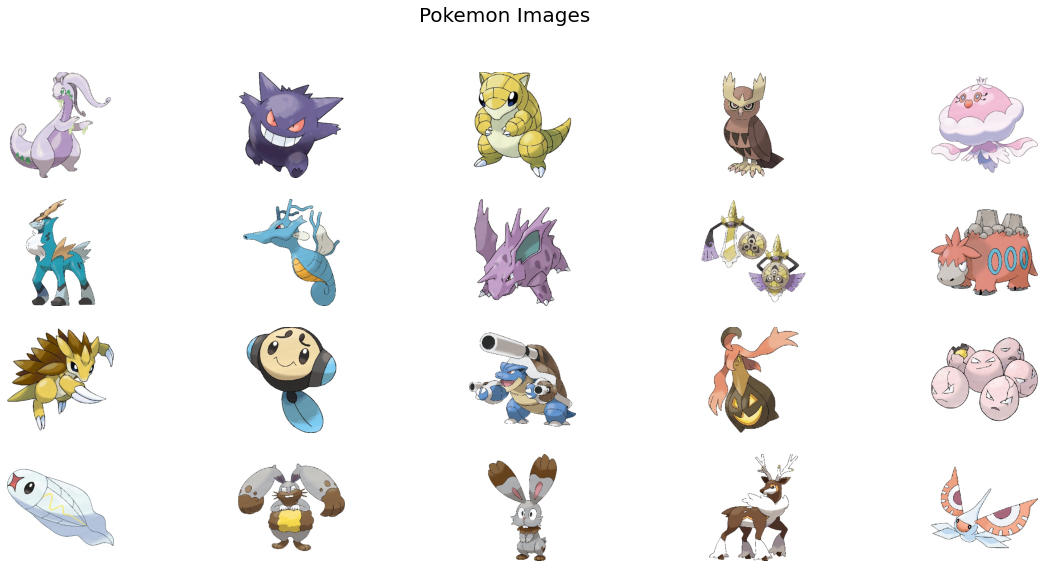

In [11]:
# displaying pokemon image into 256x256 size
display( image_dir )

Now arbitarily checking image pixel value distribution

In [12]:
import numpy as np
# arbitary image path
arb_img_path = '/content/pokemon_jpg/pokemon_jpg/211.jpg'
# loading the image
arb_img = np.array(cv2.imread(arb_img_path))
print(f'Minimum pixel value : {min(arb_img.flatten())} ,  Maximum pixel value : {max(arb_img.flatten())}')


Minimum pixel value : 0 ,  Maximum pixel value : 255


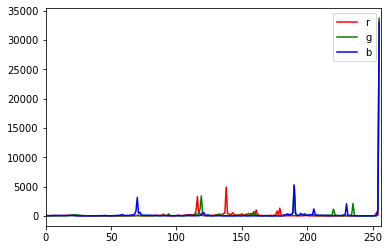

In [13]:
# pixel value distribution
# code taken from https://stackoverflow.com/questions/12182891/plot-image-color-histogram-using-matplotlib
color = ('r','g','b')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist( [arb_img] , [i] , None , [256] , [0 , 256])
    plt.plot(histr , color = col , label = str(col))
    plt.xlim([0,256])
plt.legend()
plt.show()

We can see the colours are distributed in 0 to 255 pixel values. For ease of model training , the images will be scaled into 0 to 1 range.

# 2. Image Preprocessing & Dataset Preparation :
---
Now we have seen the background and the pixel value distributions. Now we have to prepare the train and validation dataset to train and find best tuning model.

In [14]:
# Loading Libraries for data preprocessing and Augmentation
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator as GEN

In [15]:
# Only augmenting the train datas as more data need 
# to find the best fitted model and reduce bias.

# train data generator
train_augment = GEN(
    rescale = 1. / 255 ,
    horizontal_flip = True , 
    zoom_range = 0.1 ,
    shear_range = 0.1 ,
    validation_split = 0.2 , 
)

# validation data generator
val_augment = GEN(
    rescale = 1. / 255 ,
    validation_split = 0.2 , 
)

In [16]:
# Folder containing image folder.
# As we need to fit the data into the generator 
# we need the pass the image directory , not the folder.
im_folder = '/content/pokemon_jpg'

In [17]:
# datagenartor hyperparameters
IMG_SHAPE = (128 , 128)
BATCH_SIZE = 10
SEED = 42

In [18]:
# creating train dataset
train_data = train_augment.flow_from_directory(
    im_folder , 
    target_size = IMG_SHAPE ,
    batch_size = BATCH_SIZE , 
    subset = 'training' , 
    class_mode = None , 
    seed = SEED , 
)
# creay=ting validation daatset
val_data = val_augment.flow_from_directory(
    im_folder , 
    target_size = IMG_SHAPE , 
    batch_size = BATCH_SIZE , 
    subset = 'validation' , 
    class_mode = None , 
    seed = SEED , 
)

Found 656 images belonging to 1 classes.
Found 163 images belonging to 1 classes.


In [19]:
# function to check data generated after augmentation
def patch_visualize(data_patch , train = True):
    
    fig , ax = plt.subplots( 2 , 5 , figsize = (20 , 12))
    plt.suptitle('Data Visualization' , size = 18)
    for i in range(10):
        
        plt.subplot(2 , 5 , i + 1 )
        plt.imshow(data_patch[i])
        plt.axis('off')
        
    plt.show()

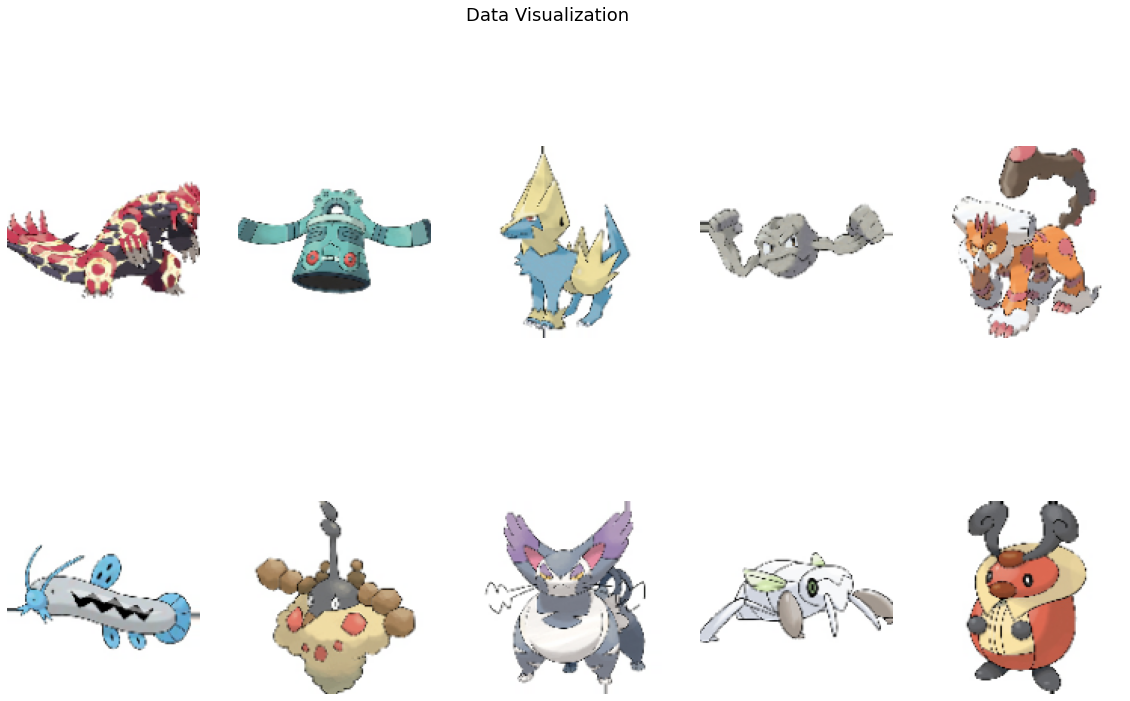

In [20]:
# visualizing training data
patch_visualize(train_data[0])

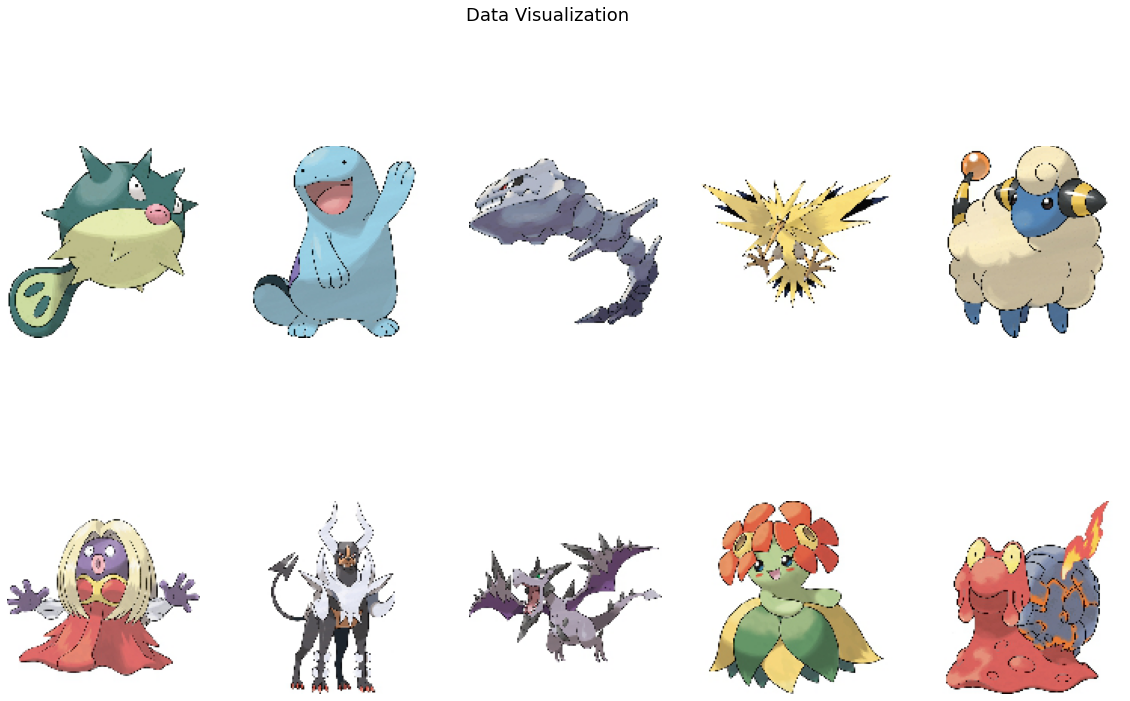

In [21]:
# visualizing test data
patch_visualize(val_data[0] , train = False)

# 3. Model Building:
---

As we have generated the train and validation data we can now move to model generation part.
The model is used in this notebook is a [Convolutional Autoencoder](https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763).


In [22]:
# imporing libraries to create Convolutional AutoEncoder Network

from tensorflow.keras.layers import (
    Input , Conv2D , Conv2DTranspose , MaxPooling2D , UpSampling2D   # model layers
)
from tensorflow.keras.models import Model                            # functional model
from tensorflow.keras.losses import MeanSquaredError                 # loss metric
from tensorflow.keras.optimizers import Adam                         # optimizer

In [23]:
class CAE():
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.c1 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.c2 = Conv2D(8, (3, 3), activation='relu', padding='same')
        self.c3 = Conv2D(8, (3, 3), activation='relu', padding='same')
        self.pool = MaxPooling2D((2, 2))
        self.ct1 = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')
        self.ct2 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')
        self.ct3 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')
        self.ups = UpSampling2D((2, 2))
    
    def network(self):
        input_layer = Input(shape=self.input_shape)
        x = self.c1(input_layer)
        x = self.pool(x)
        x = self.c2(x)
        x = self.pool(x)
        x = self.c3(x)

        code_layer = self.pool(x)

        x = self.ct3(code_layer)
        x = self.ups(x)
        x = self.ct2(x)
        x = self.ups(x)
        x = self.ct1(x)
        x = self.ups(x)
        output_layer = Conv2D(3, (3, 3), padding='same', name="Output_layer")(x)
        
        model = Model( inputs = input_layer , outputs = output_layer , name = 'Poke_CAE')
        return model

The encoder and decoder network are mirror-identical in this notebook.

In [24]:
# model class
cae = CAE(IMG_SHAPE + (3,))

In [25]:
# loading the model in backend

# refershing the session
keras.backend.clear_session()

model = cae.network()

#visualizing the model architecture
model.summary()

Model: "Poke_CAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    multiple             0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]                   
___________________________________________________________________________________________

# 4. Hyperparameters:
---

In [26]:
EPOCHS = 10
loss_fn = MeanSquaredError()
optimizer = Adam(1e-4)
steps_per_epoch = 1500
loss_tracker_index = steps_per_epoch // 10

# 5. Model Training :
---

In [27]:
import time

# for storing the loss data
train_loss_counter = []
val_loss_counter = []

for epoch in range(EPOCHS) :
    
    # storing the time
    start_time = time.time()
    print(f'Epoch : {epoch + 1}')
    print('Train Loss : [',end = " ")
    
    for index, patch in enumerate(train_data):
        
        with tf.GradientTape() as tape:
            # finding loss
            outputs = model(patch , training = True)
            patch_loss = loss_fn(patch , outputs)
            
        # applying gradients on model weights
        grads = tape.gradient(patch_loss , model.trainable_weights)
        optimizer.apply_gradients(zip(grads , model.trainable_weights))
        # printing loss
        if index % loss_tracker_index == 0:
          print('%.5f'%(float(patch_loss)) , end = " , " if index != steps_per_epoch else " ]\n")
        if index == steps_per_epoch:
          train_loss_counter.append(patch_loss)
          break
    # validation loss
    tot_val_loss = 0
    for index , val_patch in enumerate(val_data):
        
        val_output = model(val_patch , training = False)
        tot_val_loss += loss_fn(val_patch , val_output)
        
        if index == steps_per_epoch // 10:
            break
    print('Validation Loss : %.4f'%(tot_val_loss / index))
    
    val_loss_counter.append(tot_val_loss / index)
    
    print('Time taken for epoch %d : %.2f seconds.'%(epoch + 1 , time.time() - start_time ))
    print('...................................................\n\n')
print('Training Complete !!')

Epoch : 1
Train Loss : [ 0.75258 , 0.09227 , 0.04683 , 0.03814 , 0.03300 , 0.03021 , 0.02641 , 0.02677 , 0.02431 , 0.02132 , 0.02079 ]
Validation Loss : 0.0303
Time taken for epoch 1 : 122.20 seconds.
...................................................


Epoch : 2
Train Loss : [ 0.02135 , 0.01612 , 0.01903 , 0.02143 , 0.02416 , 0.01919 , 0.02073 , 0.01860 , 0.02021 , 0.01884 , 0.01554 ]
Validation Loss : 0.0268
Time taken for epoch 2 : 90.42 seconds.
...................................................


Epoch : 3
Train Loss : [ 0.01855 , 0.01706 , 0.01490 , 0.01668 , 0.01729 , 0.01703 , 0.01821 , 0.01686 , 0.01961 , 0.01592 , 0.01776 ]
Validation Loss : 0.0241
Time taken for epoch 3 : 90.76 seconds.
...................................................


Epoch : 4
Train Loss : [ 0.01589 , 0.01368 , 0.01667 , 0.01503 , 0.01389 , 0.01438 , 0.01220 , 0.01476 , 0.01460 , 0.01489 , 0.01381 ]
Validation Loss : 0.0228
Time taken for epoch 4 : 90.36 seconds.
.....................................

# 6. Model Performance Evaluation :
---
Now, the model has to be validated if it is overfitiing or underfitting.

#### Loss Curve :

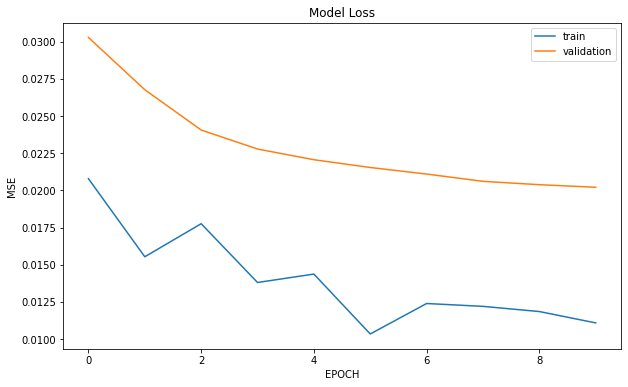

In [28]:
plt.figure( figsize = (10 , 6))
plt.title('Model Loss')
plt.plot(train_loss_counter , label = 'train')
plt.plot(val_loss_counter , label = 'validation')
plt.legend()
plt.xlabel('EPOCH')
plt.ylabel('MSE')
plt.show()

The loss curve looks quite well.

In [29]:
# function to visualize model performance
def visualize(data_patch , model , train = True):
    
    #predict over data
    pred_patch = model.predict( data_patch )
    fig , ax = plt.subplots( 4 , 4 , figsize = (20 , 8))
    if train:
        plt.suptitle('Model Evaluation on Train Data' , size = 18)
    else:
        plt.suptitle('Model Evaluation on Validation' , size = 18)
    for i in range(8):
        
        plt.subplot(4 , 4 , i*2 + 1 )
        plt.imshow(data_patch[i])
        plt.title('Image')
        plt.axis('off')
        plt.subplot(4 , 4 , i*2 + 2 )
        plt.imshow(pred_patch[i])
        plt.title('Predicted')
        plt.axis('off')
        
    plt.show()
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


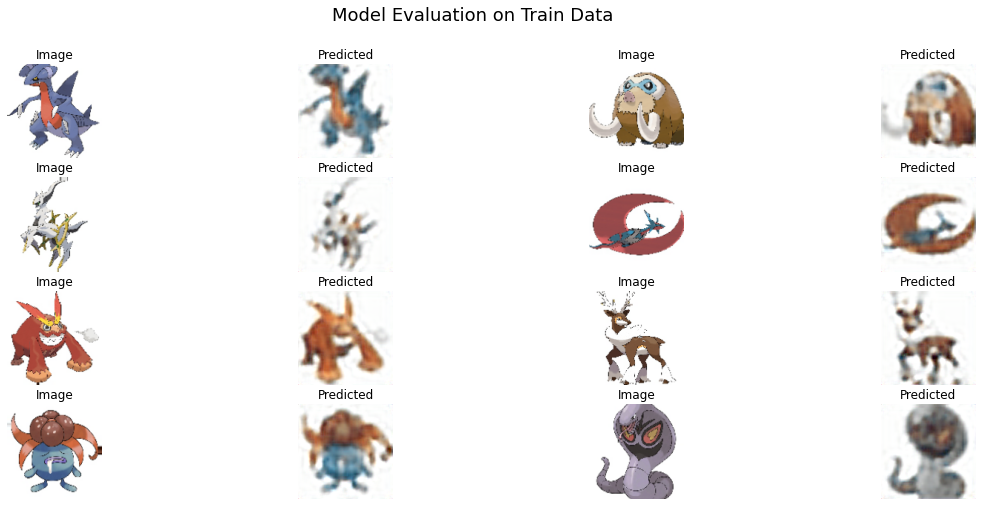

In [30]:
# Visualizing on Train data
train_data_patch = train_data[0]

visualize( train_data_patch , model )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


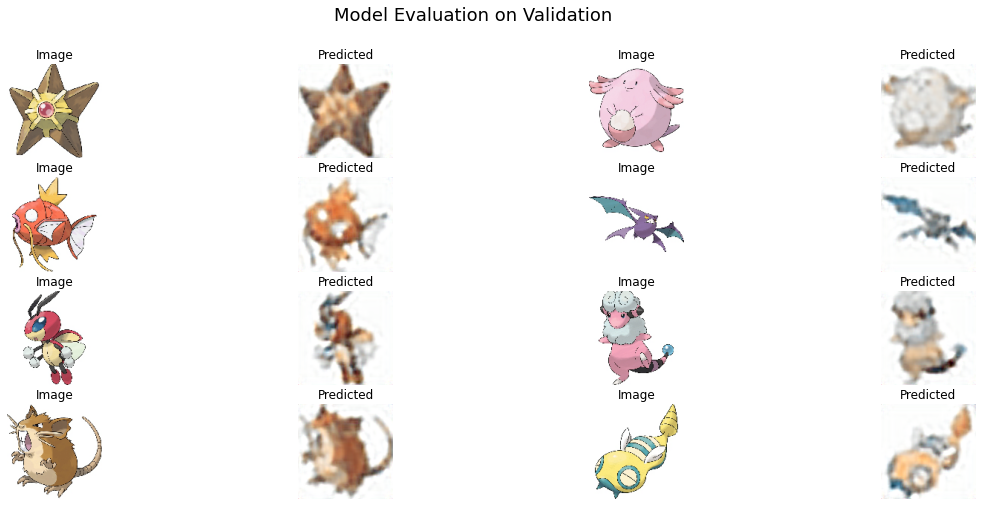

In [31]:
# Visualizing on validation data
validation_data_patch = val_data[0]

visualize( validation_data_patch , model , train = False)

**NOTE** : In this training we can see that the fetures were extraxted correctly , but the colour complexion and quality reduced due to short core lyer. If we store a larger core layer , this may diminish too. This was done on purpose to share this phenomena.

In addition, regenerating the poekmon images is a tough job too, as they have too much variety of textures and colours and all are unique and different in it's own way, so this also can be said as a tough task.

#  7. Encoder Preparation :
---
Now from that we can take the encoder part and use it for encoding similar images.

In [32]:
# Encoder

encoder = Model(inputs = model.input , outputs = model.get_layer('conv2d_transpose_2').output , name = 'Poke_Encoder')  
# conv2d_transpose_2 layer represents the core

encoder.summary()

Model: "Poke_Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    multiple             0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]                   
_______________________________________________________________________________________

# 8. Conclusion :
---
The notebook correctly shows that too much redueed information will not generate much accurate data. So, we have to choose the correct architecture.



# THANK YOU for visiting :)

## Do visit my other works at [kaggle](https://kaggle.com/sagnik1511/code) and also at [github](https://github.com/sagnik1511).

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2edELXRE4BWsVCsiwU81wwtbjGnCyseMR7Q&usqp=CAU)